In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OrdinalEncoder
from textblob import TextBlob
from wordcloud import WordCloud

In [2]:
class FakeNewsPipeline:
    def __init__(self, train_file, test_file, valid_file, columns):
        self.train_file = train_file
        self.test_file = test_file
        self.valid_file = valid_file
        self.columns = columns

    def load_data(self):
        self.train_df = pd.read_csv(self.train_file, sep=',', names=self.columns)
        self.test_df = pd.read_csv(self.test_file, sep=',', names=self.columns)
        self.valid_df = pd.read_csv(self.valid_file, sep=',', names=self.columns)
        print("Data Loaded Successfully!")
        return self.train_df, self.test_df, self.valid_df

    def handle_missing_values(self):
        # Dropping column
        self.train_df.drop(['ID'], axis=1, inplace=True)
        self.test_df.drop(['ID'], axis=1, inplace=True)
        self.valid_df.drop(['ID'], axis=1, inplace=True)
        
        # Removing rows with values missing from max. columns
        rows_to_drop = [1280, 2154, 6132, 6193, 7571, 9404]
        self.train_df.drop(index=rows_to_drop, inplace=True)

        # Visualize missing values
        sns.heatmap(self.train_df.isnull(), cbar=False, yticklabels = False, cmap="cividis")
        plt.title("Missing Values in Train Dataset")
        plt.show()
     
        categorical_columns = ['Job Title', 'State', 'Context', 'Party', 'Speaker']
        for df in [self.train_df, self.test_df, self.valid_df]:
            df[categorical_columns] = df[categorical_columns].fillna('Unknown')
        
        print("Missing Values Handled and Unnecessary Rows and Column Dropped!")
        return self.train_df, self.test_df, self.valid_df
    
    def categorize_party(self):
        # Define threshold and categorize
        threshold = 200
        party_counts = self.train_df['Party'].value_counts()
        frequent_parties = party_counts[party_counts > threshold].index.tolist()
        
        # Categorize parties in all datasets
        for df in [self.train_df, self.test_df, self.valid_df]:
            df['Party_Categorized'] = df['Party'].apply(lambda x: x if x in frequent_parties else 'Others')
        
        # Calculate percentage distribution of categorized parties
        party_percentage = (
            self.train_df['Party_Categorized']
            .value_counts(normalize=True) * 100
        ).reset_index()
        party_percentage.columns = ['Party', 'Percentage']
        
        # Plot as a bar graph
        plt.figure(figsize=(6, 4))
        sns.barplot(
            x=party_percentage['Party'],
            y=party_percentage['Percentage'],
            palette="viridis"
        )
        plt.title("Categorized Party Affiliation % Distribution", fontsize=16)
        plt.xlabel("Party", fontsize=12)
        plt.ylabel("Percentage", fontsize=12)
        plt.xticks(rotation=45)
        plt.show()
        
        print("Party Categorization Completed!")
        return self.train_df, self.test_df, self.valid_df

    def clean_text(self):
        def clean_statement(text):
            text = text.lower()
            
            text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
            text = re.sub(r'\W', ' ', text)  # Remove non-word characters
            text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
            stop_words = set(stopwords.words('english'))
            lemmatizer = WordNetLemmatizer()
            text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
            return text
        
        for df in [self.train_df, self.test_df, self.valid_df]:
            df['Statement'] = df['Statement'].apply(clean_statement)
        
        print("Text Cleaning Completed!")
        return self.train_df, self.test_df, self.valid_df

    def feature_engineering(self):
        # Ordinal Encoding for Labels
        ordinal_encoder = OrdinalEncoder(categories=[['pants-fire', 'FALSE', 'barely-true', 'half-true', 'mostly-true', 'TRUE']])
        for df in [self.train_df, self.test_df, self.valid_df]:
            df['Label'] = ordinal_encoder.fit_transform(df[['Label']])
        
        # Sentiment feature
        for df in [self.train_df, self.test_df, self.valid_df]:
            df['Sentiment'] = df['Statement'].apply(lambda x: TextBlob(x).sentiment.polarity)
        
        # False Ratio feature
        for df in [self.train_df, self.test_df, self.valid_df]:
            df['False_Ratio'] = df['False Count'] / (
                df['Barely True Count'] + df['False Count'] +
                df['Half True Count'] + df['Mostly True Count'] +
                df['Pants on Fire Count']
            )
        
        print("Feature Engineering Completed!")
        return self.train_df, self.test_df, self.valid_df

    def analyze_data(self):
        numeric_df = self.train_df.select_dtypes(include=[np.number])
   
        sns.countplot(x='Label', data=self.train_df, palette='plasma')
        plt.title('Label Distribution')
        plt.show()

        # Correlation Heatmap
        correlation_matrix = numeric_df.corr() 
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
        plt.title("Feature Correlation")
        plt.show()

        # Word Cloud
        text = ' '.join(self.train_df['Statement'])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud of Statements")
        plt.show()

        sns.histplot(self.train_df['Sentiment'], bins=30, kde=True, color='blue')
        plt.title('Distribution of Sentiment Polarity')
        plt.xlabel('Sentiment Polarity')
        plt.ylabel('Frequency')
        plt.show()

        sns.countplot(x='Party_Categorized', hue='Label', data=self.train_df, palette='coolwarm')
        plt.title('Truthfulness by Political Party')
        plt.xticks(rotation=45)
        plt.show()

        top_speakers = self.train_df['Speaker'].value_counts().head(10).index
        speaker_data = self.train_df[self.train_df['Speaker'].isin(top_speakers)]
        sns.countplot(y='Speaker', hue='Label', data=speaker_data, palette='viridis')
        plt.title('Top Speakers and Truthfulness')
        plt.show()
        
        print("Data Analysis Completed!")

    def run_pipeline(self):
        self.load_data()
        self.handle_missing_values()
        self.categorize_party()
        self.clean_text()
        self.feature_engineering()
        self.analyze_data()
        print("Pipeline Execution Completed!")

Data Loaded Successfully!


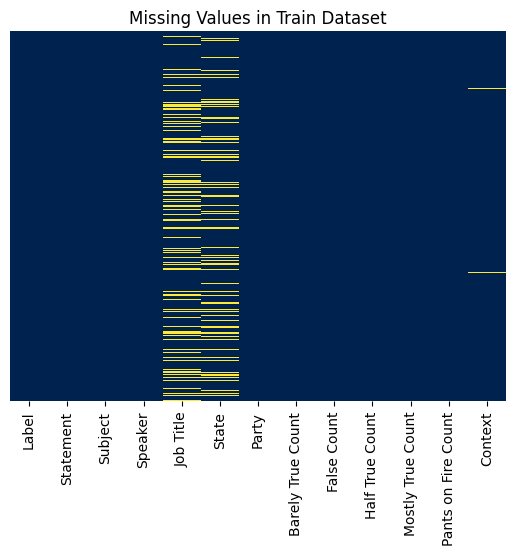

Missing Values Handled and Unnecessary Rows and Column Dropped!


C:\Users\zaraf\AppData\Local\Temp\ipykernel_7280\4145792700.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


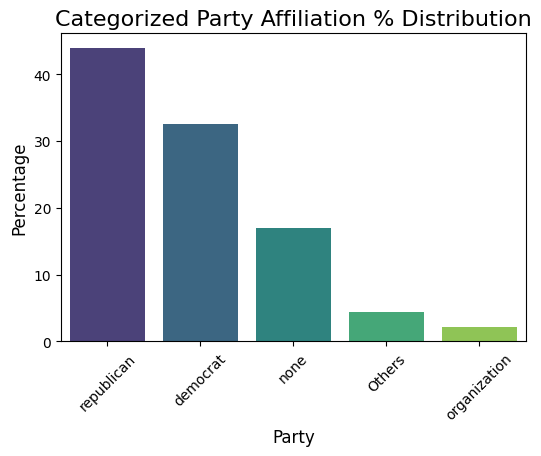

Party Categorization Completed!
Text Cleaning Completed!
Feature Engineering Completed!


C:\Users\zaraf\AppData\Local\Temp\ipykernel_7280\4145792700.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=self.train_df, palette='plasma')


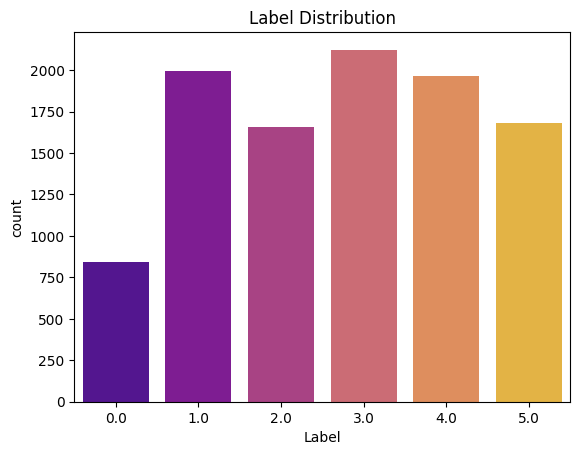

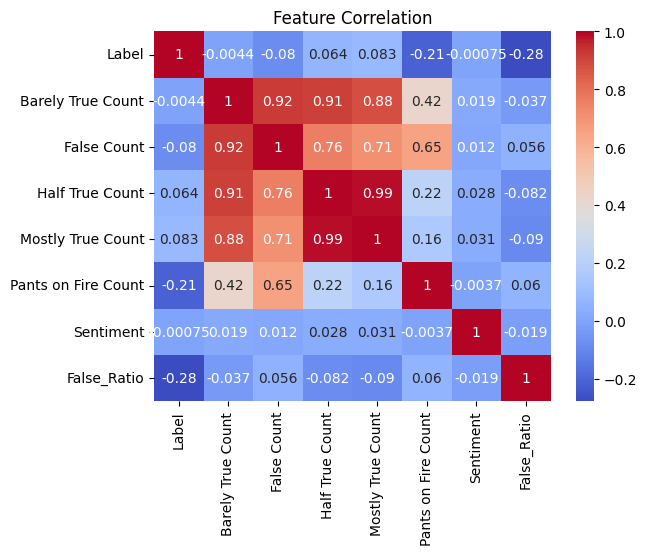

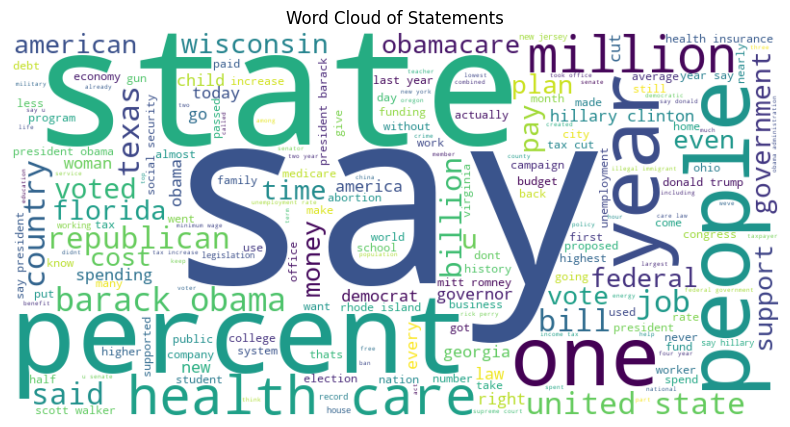

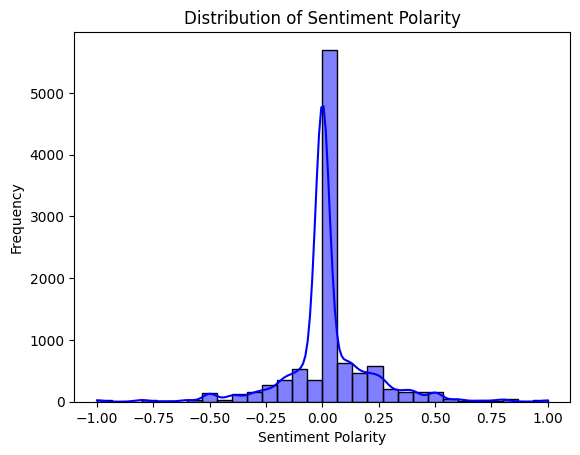

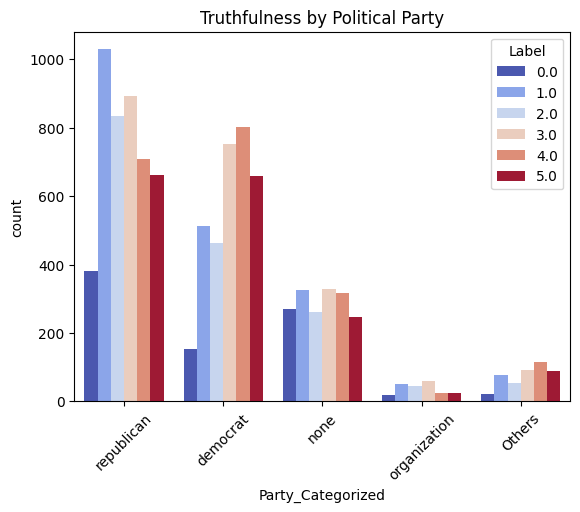

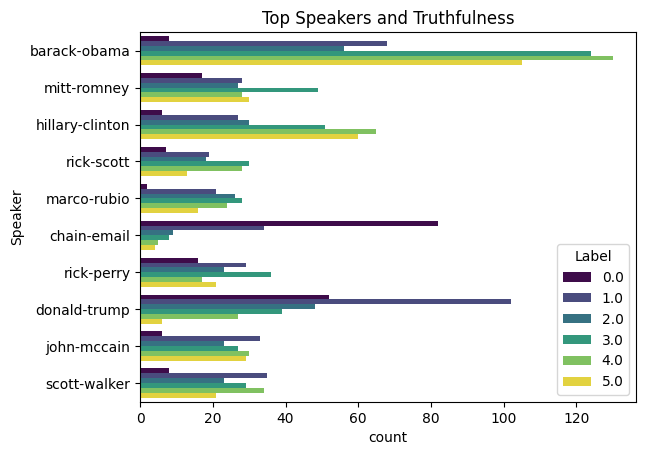

Data Analysis Completed!
Pipeline Execution Completed!


In [3]:
columns = [
    "ID", "Label", "Statement", "Subject", "Speaker", "Job Title", 
    "State", "Party", "Barely True Count", "False Count", 
    "Half True Count", "Mostly True Count", "Pants on Fire Count", "Context"
]

train_df = "train.csv"
test_df = "test.csv"
valid_df = "valid.csv"

pipeline = FakeNewsPipeline(train_df, test_df, valid_df, columns)
pipeline.run_pipeline()
